# 0.1 Importing

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'SU1N8pg8XA9UYTrFty3y'

In [3]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.
data = quandl.get('FRED/NROU')

Fortunately the Quandl data provided as an example in exerice 6.6 **"Natural Rate of Unemployment"** "connects" to my "broader research topic."

**(Source(s)** -->
"There is also a strong association between the aggregate unemployment rate and average happiness even for employed workers (correlation of –0.47). For employed workers, a one percentage point increase in the unemployment rate is associated with a 0.04 point (or 0.6%) reduction in average life satisfaction."

https://wol.iza.org/articles/unemployment-andhappiness/long#:~:text=There%20is%20also%20a%20strong,reduction%20in%20average%20life%20satisfaction. 

In [4]:
data.head(5)

Value
Date                
1949-01-01  5.255053
1949-04-01  5.261516
1949-07-01  5.268013
1949-10-01  5.274564
1950-01-01  5.281182

In [5]:
data.shape

(332, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

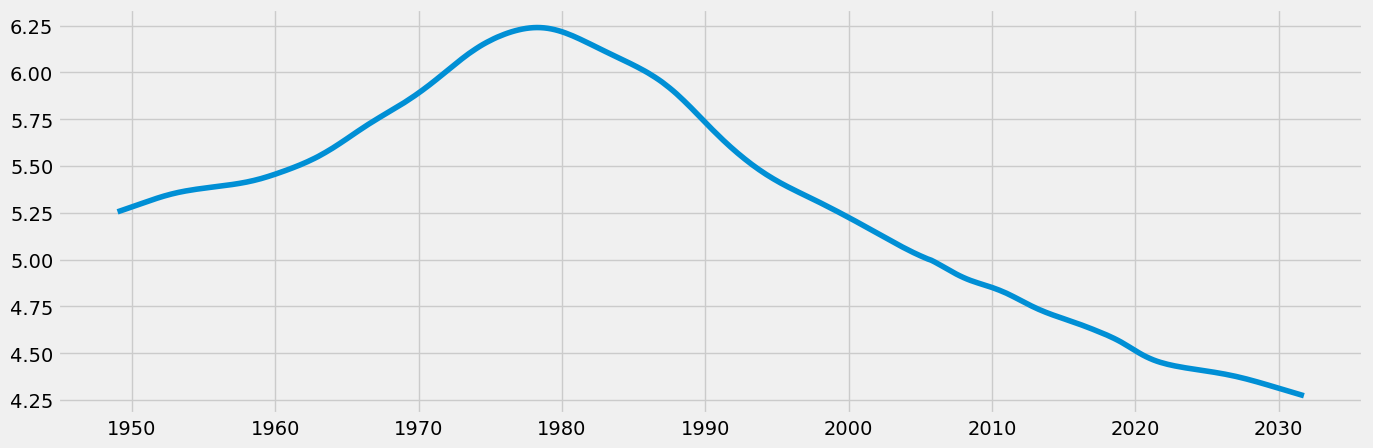

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 0.2 Directions 6.6

### 0.2-2 Subsetting

In [10]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [11]:
data_2.head()

Date     Value
0 1949-01-01  5.255053
1 1949-04-01  5.261516
2 1949-07-01  5.268013
3 1949-10-01  5.274564
4 1950-01-01  5.281182

In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [13]:
data_sub.shape

(162, 2)

In [14]:
data_sub.head()

Date     Value
124 1980-01-01  6.217371
125 1980-04-01  6.210709
126 1980-07-01  6.203388
127 1980-10-01  6.195496
128 1981-01-01  6.187123

In [15]:
# Set the "Date" column as the index
from datetime import datetime
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

Value
datetime            
1980-01-01  6.217371
1980-04-01  6.210709
1980-07-01  6.203388
1980-10-01  6.195496
1981-01-01  6.187123

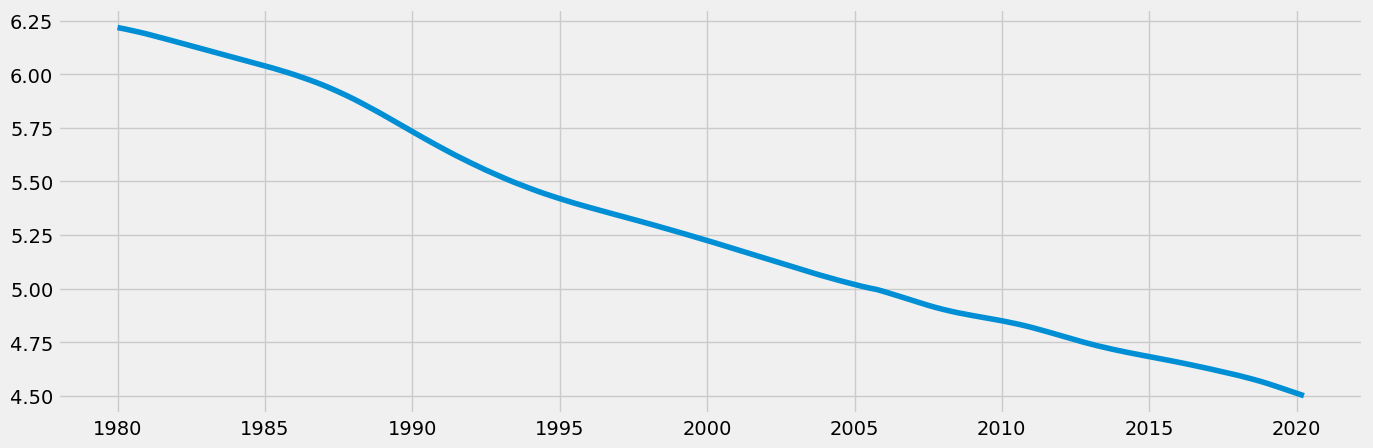

In [16]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values (you shouldn't have any)
data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()
# No duplicates

0

### 0.2-3 Time Series Analysis

In [19]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

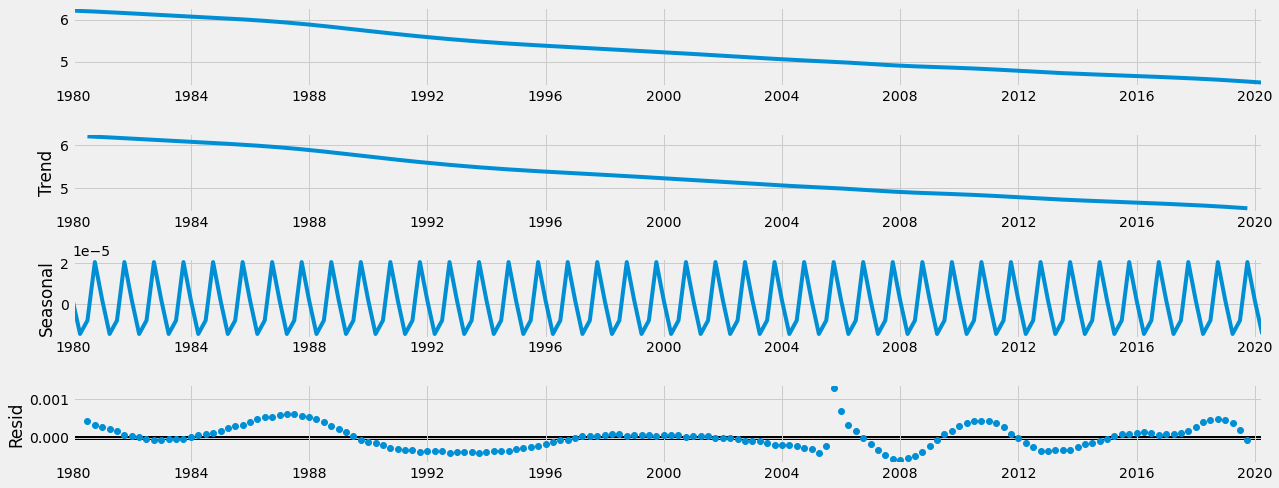

In [21]:
# Plot the separate components
decomposition.plot()
plt.show()

The **trend** appear the same because the data doesn't present huge variations.


The **residual line** presents variations that while large prior to say 2006 or 2007 exsits within a general range. Until spiking dramatically then settling again to fit that preditable range.


The **seasonal line** shows that the data has seasonality, potentially promoted by the crisis and seasonal jobs.

### 0.2-4 Testing for stationarity

In [22]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745331
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In order to determine the results of a statistical hypothesis test, one has to compare the **test statistic** to the **critical value** of the corresponding significance level. 

If the **test statistic** is larger than the **critical value**, one can’t reject the null hypothesis. 
If the **test statistic** is smaller than the **critical value**, the null hypothesis could be rejected. 

In this case, considering a significance level of 5%, the “Critical Value of 5% has a value of -2.880132. This is smaller than the **test statistic**, which is -1.745331, which means that the null hypothesis cannot be rejected.

This also means that the data is non-stationary. 

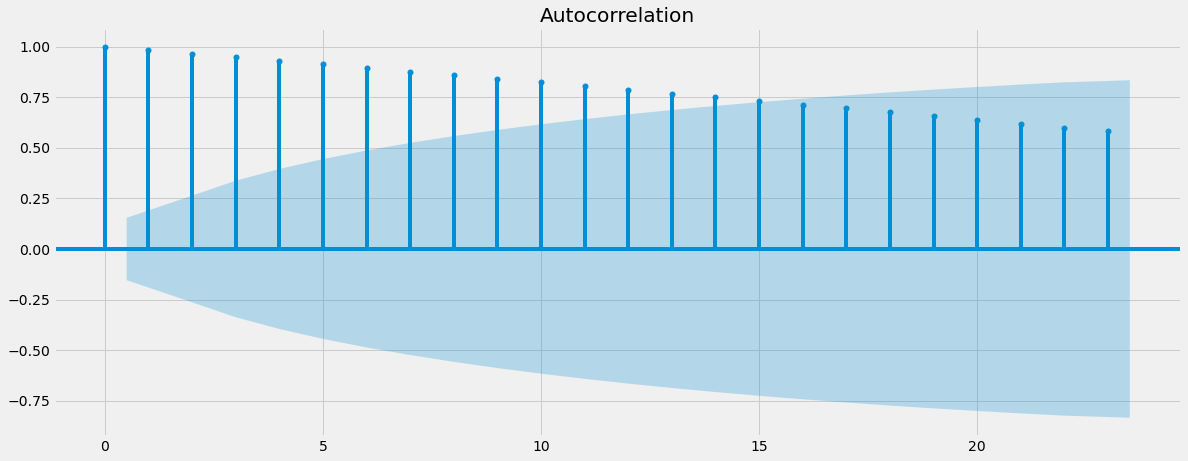

In [23]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. Thus, it can be deduced that the data is **non-stationary.**

### 0.2-5 Stationarizing data

In [24]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = data_sub - data_sub.shift(1)

In [25]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [26]:
data_diff.head()

Value
datetime            
1980-04-01 -0.006662
1980-07-01 -0.007321
1980-10-01 -0.007892
1981-01-01 -0.008373
1981-04-01 -0.008762

In [27]:
data_diff.columns

Index(['Value'], dtype='object')

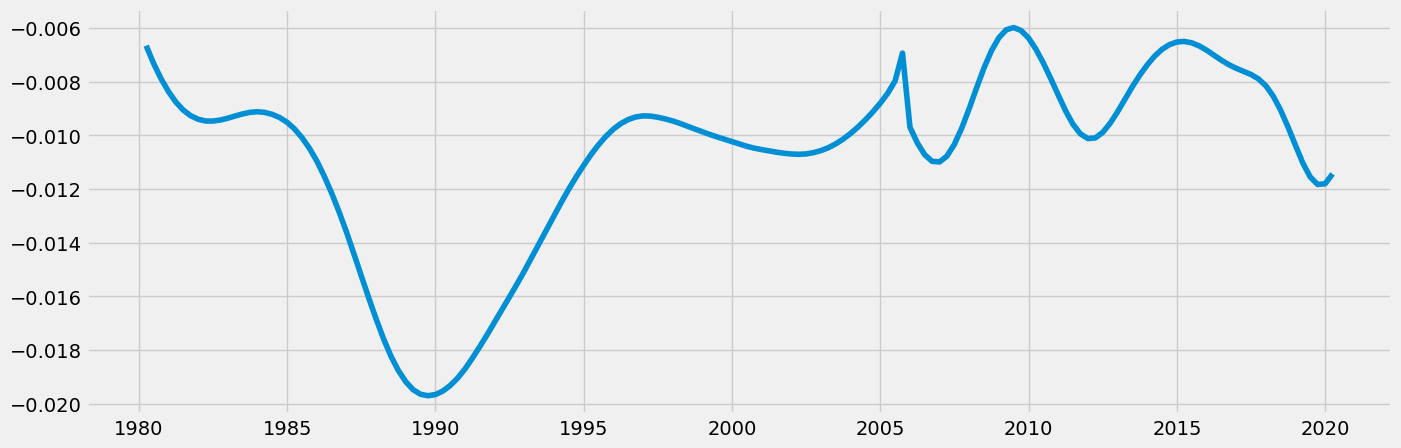

In [28]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


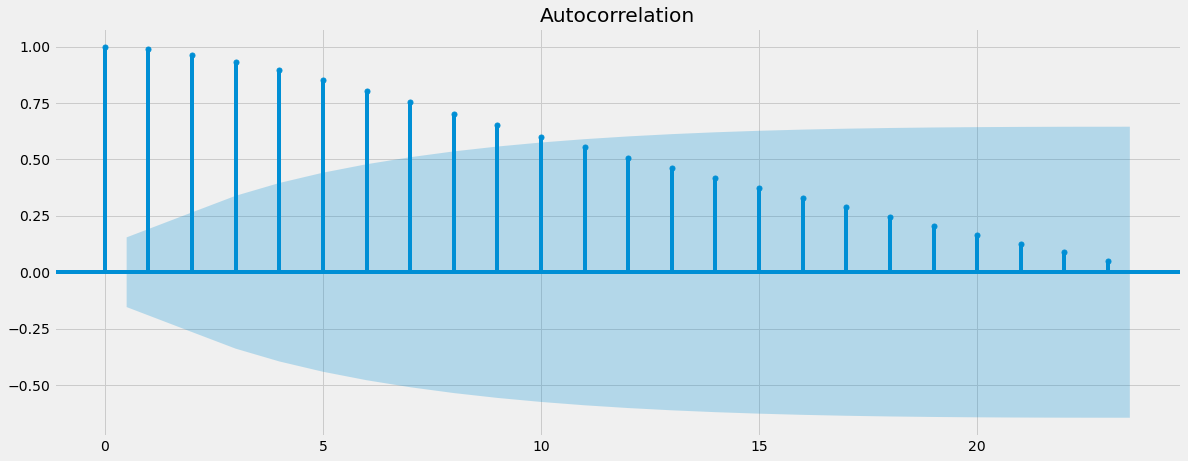

In [30]:
plot_acf(data_diff)
plt.show()

Despite the autocorrelation plot having improved, the data is still **not stationary.** And since there is not a significant amount of vertical lines above the confidence interval = blue line I don't see the need to conduct another analysis cycle.